# Instructions :
Travail en groupe, à  placer dans le premier dépot Git de notre année Universitaire, dans le dossier <code>Computer Vision</code>.


https://github.com/Lucas-Hr/TP-Algo-ML

# Membres du Groupe :

1. (ESIIA4) RAZAIARIMIHAJASOA Tsantaniony Fankasitrahana N°3   
2. (ESIIA4) RABEANTOANDRO Mirantsoa Adrianna N°12  
3. (ESIIA4) RAKOTOMALALA Nirinifitiavana Sarobidy N°15
4. (ESIIA4) ANDRIAMIARISOA Henintsoa Lucas N°19
5. (ESIIA4) RAKOTOHARIMALALA Ny hasina Sedera N°20
6. (IMTICIA4) RASOLONJATOVO Soatiana Andrianina N°12


# Autoencodeurs pour Images de Cercles

Dans ce notebook, nous allons générer un dataset synthétique où chaque image est une image en niveaux de gris de taille 64x64 contenant un cercle blanc (de centre et rayon aléatoires) sur fond noir. Le but est d'entraîner des autoencodeurs qui réduisent ces images dans un espace latent de dimension 3, puis les reconstruisent.

Nous étudierons deux configurations :
- Un autoencodeur entièrement connecté
- Un autoencodeur convolutionnel

Vous pourrez comparer leurs performances et discuter des compromis liés à la conception de l'espace latent.

## Étape 1 : Génération du Dataset

Nous allons générer un dataset d'images où chaque image comporte un cercle blanc de centre et de rayon aléatoires. Pour cela, nous utiliserons la bibliothèque OpenCV pour dessiner le cercle sur une image noire.

### Explication Pratique
La génération d'un dataset synthétique permet de contrôler précisément les paramètres (ici, le centre et le rayon du cercle) et de disposer d'une base simple pour expérimenter la réduction dimensionnelle via l'espace latent.

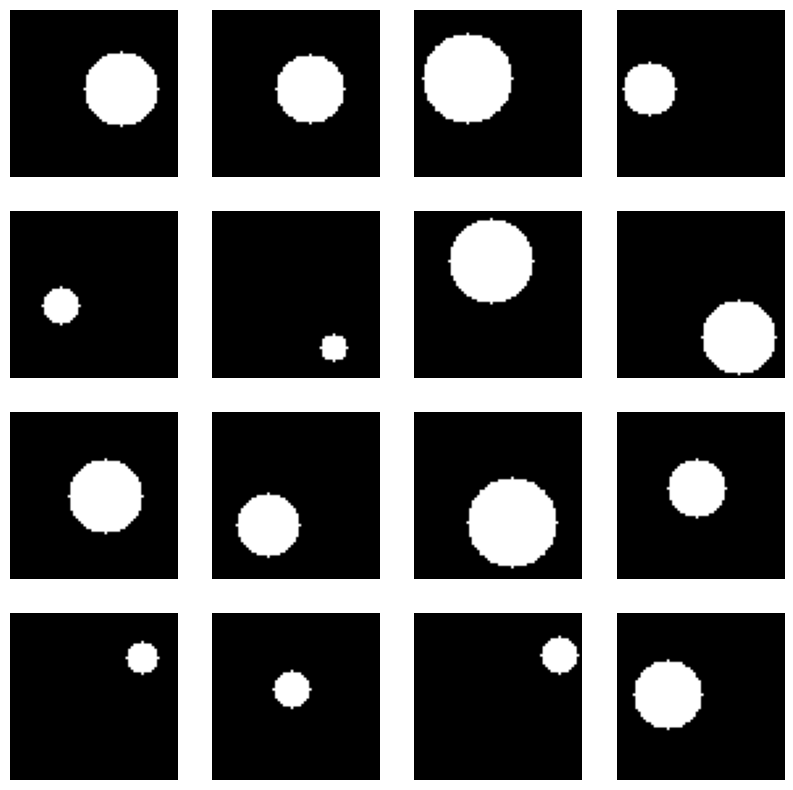

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def generate_circle_image(image_size=64, min_radius=5, max_radius=20):
    """Génère une image en niveaux de gris de taille image_size x image_size contenant un cercle blanc."""
    # Créer une image noire
    image = np.zeros((image_size, image_size), dtype=np.uint8)

    # Choisir un rayon aléatoire
    radius = np.random.randint(min_radius, max_radius)

    # Choisir un centre aléatoire de sorte que le cercle soit entièrement contenu dans l'image
    x = np.random.randint(radius, image_size - radius)
    y = np.random.randint(radius, image_size - radius)

    # Dessiner le cercle (couleur blanche: 255, épaisseur=-1 pour un remplissage complet)
    cv2.circle(image, (x, y), radius, 255, -1)

    # Normaliser l'image entre 0 et 1
    image = image.astype('float32') / 255.0

    return image

def generate_dataset(n_samples=10000, image_size=64):
    data = []
    for _ in range(n_samples):
        img = generate_circle_image(image_size=image_size)
        data.append(img)
    data = np.array(data)
    # Ajouter une dimension pour le canal (images en niveaux de gris)
    data = np.expand_dims(data, axis=-1)
    return data

# Générer le dataset
data = generate_dataset(n_samples=10000, image_size=64)

# Afficher quelques exemples
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(data[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()


## Étape 2 : Préparation des Données

Nous allons diviser le dataset en ensembles d'entraînement et de test. Ici, nous utilisons 80 % des données pour l'entraînement et 20 % pour le test.

In [2]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

print('Entraînement:', train_data.shape)
print('Test:', test_data.shape)


Entraînement: (8000, 64, 64, 1)
Test: (2000, 64, 64, 1)


## Étape 3 : Autoencodeur Entièrement Connecté (Dense Layers)

Dans cette partie, nous construisons un autoencodeur entièrement connecté. Le modèle comporte :

- **Encodeur :** Un aplatissement de l'image suivi d'une couche Dense de 128 neurones (activation ReLU) puis une couche Dense de 3 neurones qui représente l'espace latent.
- **Décodeur :** Une couche Dense de 128 neurones (activation ReLU), suivie d'une couche Dense de 4096 neurones (pour reconstruire une image 64x64) avec activation sigmoïde, puis un reshape en (64,64,1).

### Explication Pratique
Cet autoencodeur simple permet de voir comment les informations (ici, la position et la taille du cercle) sont comprimées dans un espace de très faible dimension.

In [3]:
from tensorflow.keras import layers, models

input_img = layers.Input(shape=(64, 64, 1))
x = layers.Flatten()(input_img)
x = layers.Dense(128, activation='relu')(x)
latent = layers.Dense(3, name='latent_space')(x)  # Espace latent de dimension 3

x = layers.Dense(128, activation='relu')(latent)
x = layers.Dense(64*64, activation='sigmoid')(x)
decoded = layers.Reshape((64, 64, 1))(x)

autoencoder_fc = models.Model(input_img, decoded)

autoencoder_fc.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_fc.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_space (Dense)                 │ (None, 3)                   │             387 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4096)                │         528,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 64, 64, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,053,699 (4.02 MB)

 Trainable params: 1,053,699 (4.02 MB)

 Non-trainable params: 0 (0.00 B)

### Entraînement de l'Autoencodeur Entièrement Connecté FCN (Dense layers)

Nous allons entraîner cet autoencodeur sur l'ensemble d'entraînement.

In [4]:
history_fc = autoencoder_fc.fit(train_data, train_data,
                                  epochs=20,
                                  batch_size=128,
                                  shuffle=True,
                                  validation_data=(test_data, test_data))


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.4603 - val_loss: 0.1522
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1369 - val_loss: 0.1052
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1004 - val_loss: 0.0877
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0852 - val_loss: 0.0788
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0787 - val_loss: 0.0742
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0739 - val_loss: 0.0718
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0718 - val_loss: 0.0695
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0699 - val_loss: 0.0682
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0678 - val_loss: 0.0669
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0663 - val_loss: 0.0655
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0651 - val_loss: 0.0648
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0639 - val_l

### Visualisation des Reconstructions (FC)

Affichons quelques reconstructions pour évaluer qualitativement les performances de l'autoencodeur entièrement connecté.

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


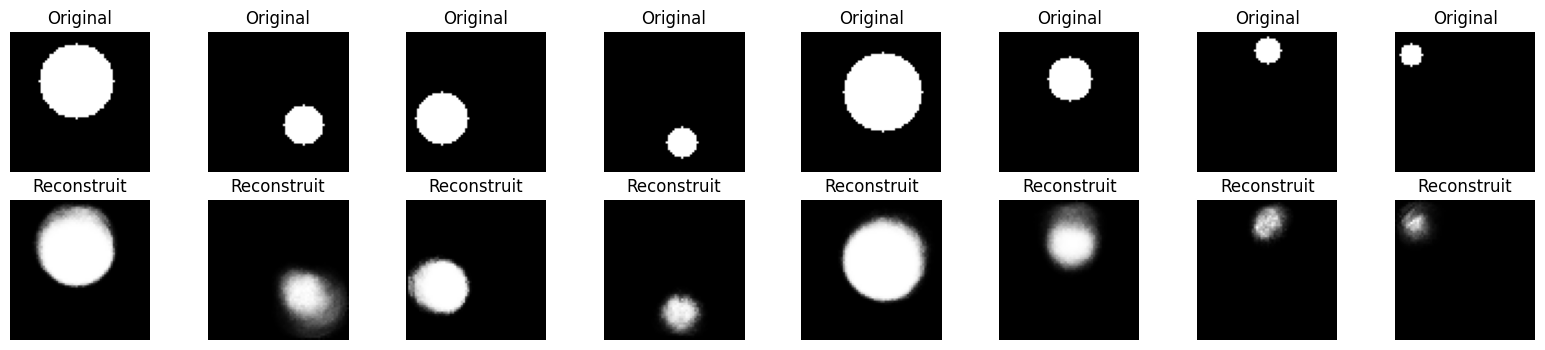

In [5]:
decoded_imgs_fc = autoencoder_fc.predict(test_data)

n = 8
plt.figure(figsize=(20, 4))
for i in range(n):
    # Afficher l'image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_data[i].squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Afficher l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_fc[i].squeeze(), cmap='gray')
    plt.title('Reconstruit')
    plt.axis('off')
plt.show()


### Test du modèle autoencodeur entièrement connecté
Ajout de bruit gaussien et un masquage partiel sur les images.

In [6]:
from tensorflow.keras.models import load_model

# Ajouter du bruit gaussien
def add_noise(image, noise_level=0.2):
    noise = np.random.normal(0, noise_level, image.shape)
    return np.clip(image + noise, 0, 1)

# Ajouter un masquage partiel
def add_mask(image, mask_size=20):
    masked_img = image.copy()
    x = np.random.randint(0, image.shape[0] - mask_size)
    y = np.random.randint(0, image.shape[1] - mask_size)
    masked_img[x:x+mask_size, y:y+mask_size] = 0  # Zone noire masquée
    return masked_img

In [7]:
# Générer un dataset de test
num_samples = 10
original_images = np.array([generate_circle_image() for _ in range(num_samples)])

# Appliquer bruit + masquage sur la même image
noisy_images = np.array([add_noise(img) for img in original_images])
noisy_masked_images = np.array([add_mask(img) for img in noisy_images])

# Reshape pour correspondre à l'entrée du modèle
original_images = np.expand_dims(original_images, axis=-1)
noisy_masked_images = np.expand_dims(noisy_masked_images, axis=-1)

# Passer les images bruitées et masquées dans l'autoencodeur
decoded_images = autoencoder_fc.predict(noisy_masked_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


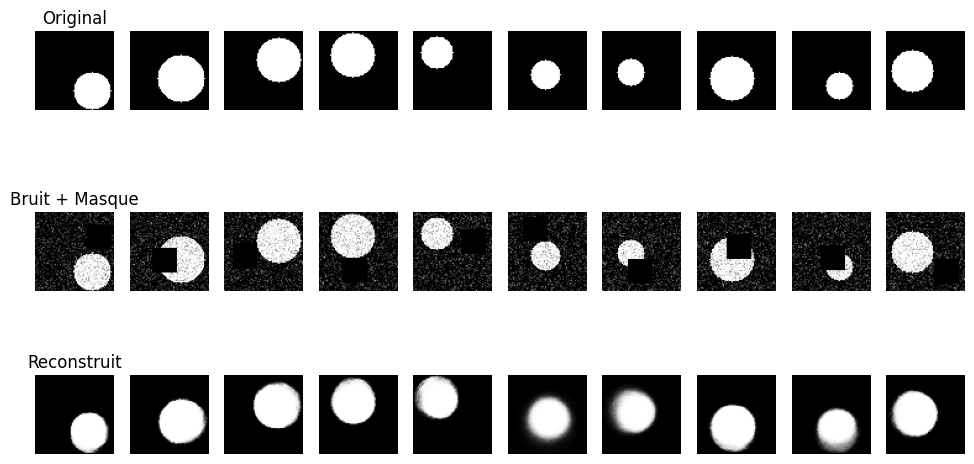

In [8]:
# Visualiser les résultats
n = num_samples
plt.figure(figsize=(12, 6))
for i in range(n):
    # Image originale
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(original_images[i].squeeze(), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title("Original")

    # Image bruitée + masquée
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(noisy_masked_images[i].squeeze(), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title("Bruit + Masque")

    # Image reconstruite
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_images[i].squeeze(), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title("Reconstruit")

plt.show()

### Interprétation des résultats

Lorsque les images originales sans altération sont passées à l’autoencodeur, les reconstructions sont assez fidèles à l’original. Le modèle a bien appris à capturer la présence du cercle et sa position dans l’image. Toutefois, les bords du cercle semblent légèrement flous, ce qui est typique d’un autoencodeur entièrement connecté qui ne capture pas bien les structures spatiales.

Pour le cas des images bruitées et masquées, la reconstruction du cercle semble moins précise, avec des bords plus diffus. Dans certains cas, la position du cercle n'est pas parfaitement alignée avec l'original. Le modèle peine à retrouver la bonne taille et la bonne position.

## Étape 4 : Autoencodeur Convolutionnel

Nous allons maintenant construire un autoencodeur convolutionnel. Cette architecture est généralement mieux adaptée pour traiter des images car elle exploite la structure spatiale.

### Architecture
- **Encodeur :**
  - Conv2D(32, 3, activation='relu', padding='same')
  - MaxPooling2D((2,2), padding='same')
  - Conv2D(64, 3, activation='relu', padding='same')
  - MaxPooling2D((2,2), padding='same')
  - Flatten puis Dense(3) pour obtenir le latent space
- **Décodeur :**
  - Dense(16*16*64, activation='relu') puis Reshape en (16,16,64)
  - Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')
  - Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same')
  - Conv2D(1, 3, activation='sigmoid', padding='same') pour reconstruire l'image

### Explication Pratique
Les autoencodeurs convolutionnels capturent mieux la structure locale des images, ce qui peut améliorer la qualité des reconstructions par rapport à une architecture entièrement connectée.

In [9]:
input_img = layers.Input(shape=(64, 64, 1))

# Encodeur
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Flatten()(x)
latent = layers.Dense(3, name='latent_space')(x)

# Décodeur
x = layers.Dense(16*16*64, activation='relu')(latent)
x = layers.Reshape((16,16,64))(x)
x = layers.Conv2DTranspose(64, (3,3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same')(x)
decoded = layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

autoencoder_conv = models.Model(input_img, decoded)

autoencoder_conv.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_conv.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_space (Dense)                 │ (None, 3)                   │          49,155 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16384)               │          65,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 189,188 (739.02 KB)

 Trainable params: 189,188 (739.02 KB)

 Non-trainable params: 0 (0.00 B)

### Entraînement de l'Autoencodeur Convolutionnel

Entraînons cet autoencodeur sur le même ensemble d'entraînement.

In [10]:
history_conv = autoencoder_conv.fit(train_data, train_data,
                                  epochs=20,
                                  batch_size=128,
                                  shuffle=True,
                                  validation_data=(test_data, test_data))


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 114ms/step - loss: 0.5348 - val_loss: 0.2659
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.2347 - val_loss: 0.1715
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.1565 - val_loss: 0.1001
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0921 - val_loss: 0.0693
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0662 - val_loss: 0.0615
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0512 - val_loss: 0.0418
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0401 - val_loss: 0.0354
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0372 - val_loss: 0.0306
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0309 - val_loss: 0.0332
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0299 - val_loss: 0.0259
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0246 - val_loss: 0.0240
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0

### Visualisation des Reconstructions (Convolutionnel)

Affichons quelques reconstructions pour comparer qualitativement les deux architectures.

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


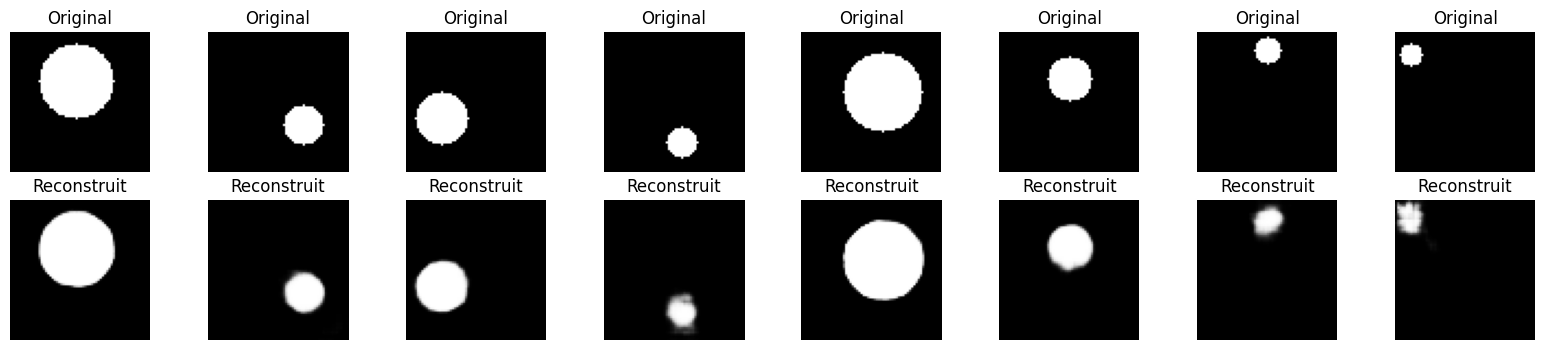

In [11]:
decoded_imgs_conv = autoencoder_conv.predict(test_data)

n = 8
plt.figure(figsize=(20, 4))
for i in range(n):
    # Afficher l'image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_data[i].squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Afficher l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_conv[i].squeeze(), cmap='gray')
    plt.title('Reconstruit')
    plt.axis('off')
plt.show()


## Expérimentations

1. Tester les deux modèles sur des images d'entrées imparfaites (avec les imperfections de votre choix : parties cachées, bruits, ...). Interpréter les résultats.
2. Améliorer un des modèles ci-dessus de votre choix et montrer le résultat (sans modifier la taille de l'espace latent).
3. Selon les expériences menées dans ce notebook, votre avis et vos conaissances, est-il nécessaire d'augmenter la taille de l'espace latent pour avoir un réseau à faire ce travail. **Argumenter** votre réponse.

## Réponse 2 : Amélioration de l'autoencodeur entièrement connecté

Nous avons amélioré l'autoencodeur en ajoutant plus de couches pour mieux capturer les caractéristiques des images. La normalisation par batch stabilise l'entraînement, tandis que le dropout et la régularisation L1 limitent le surapprentissage. La fonction de perte a été optimisée avec l'erreur quadratique moyenne (MSE) pour une meilleure reconstruction. Enfin, nous avons testé la robustesse du modèle en lui soumettant des images bruitées et masquées afin d'évaluer sa capacité à restaurer les données perdues.

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 0.1595 - val_loss: 0.0797 - learning_rate: 0.0010
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0510 - val_loss: 0.0543 - learning_rate: 0.0010
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0424 - val_loss: 0.0410 - learning_rate: 0.0010
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0386 - val_loss: 0.0374 - learning_rate: 0.0010
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0353 - val_loss: 0.0318 - learning_rate: 0.0010
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0325 - val_loss: 0.0284 - learning_rate: 0.0010
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0292 - val_loss: 0.0257 - learning_rate: 0.0010
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0269 - val_loss: 0.0247 - learning_rate: 0.0010
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0255 - val_loss: 0.0221 - learning_rate: 0.0010
Epoch 10/50
63/63 ━━━━━━━━━

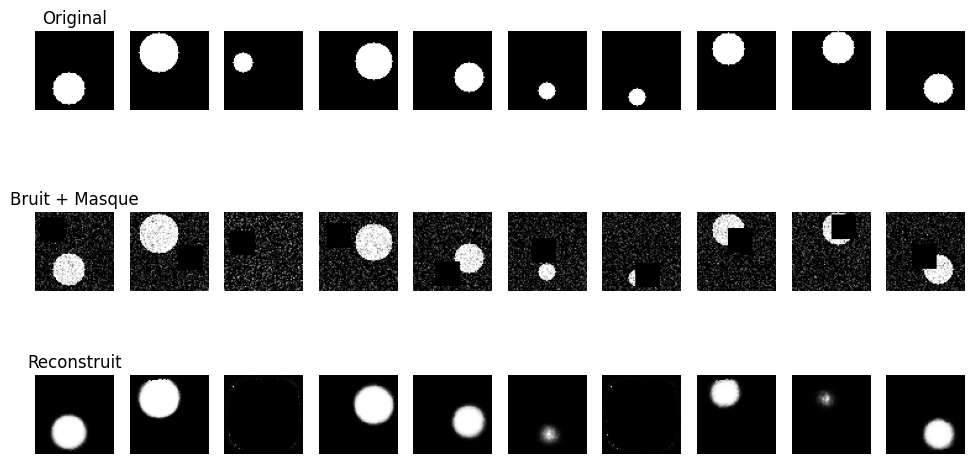

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Génération d'une image avec un cercle blanc
def generate_circle_image(image_size=64, min_radius=5, max_radius=20):
    image = np.zeros((image_size, image_size), dtype=np.uint8)
    radius = np.random.randint(min_radius, max_radius)
    x = np.random.randint(radius, image_size - radius)
    y = np.random.randint(radius, image_size - radius)
    cv2.circle(image, (x, y), radius, 255, -1)
    return image.astype('float32') / 255.0

# Génération du dataset
def generate_dataset(n_samples=10000, image_size=64):
    data = np.array([generate_circle_image(image_size=image_size) for _ in range(n_samples)])
    return np.expand_dims(data, axis=-1)

# Génération des données
data = generate_dataset(n_samples=10000, image_size=64)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Modèle d'Autoencodeur amélioré
input_img = layers.Input(shape=(64, 64, 1))
x = layers.Flatten()(input_img)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
latent = layers.Dense(3, activity_regularizer=regularizers.l1(1e-5), name='latent_space')(x)

x = layers.Dense(128, activation='relu')(latent)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(64*64, activation='sigmoid')(x)
decoded = layers.Reshape((64, 64, 1))(x)

autoencoder_fc = models.Model(input_img, decoded)
autoencoder_fc.compile(optimizer='adam', loss='mse')

# Entraînement avec réduction dynamique du learning rate
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
history_fc = autoencoder_fc.fit(train_data, train_data, epochs=50, batch_size=128,
                                shuffle=True, validation_data=(test_data, test_data),
                                callbacks=[lr_scheduler])

# Ajout de bruit et de masquage
def add_noise(image, noise_level=0.2):
    noise = np.random.normal(0, noise_level, image.shape)
    return np.clip(image + noise, 0, 1)

def add_mask(image, mask_size=20):
    masked_img = image.copy()
    x, y = np.random.randint(0, image.shape[0] - mask_size), np.random.randint(0, image.shape[1] - mask_size)
    masked_img[x:x+mask_size, y:y+mask_size] = 0
    return masked_img

# Génération d'images bruitées et masquées
num_samples = 10
original_images = np.array([generate_circle_image() for _ in range(num_samples)])
noisy_masked_images = np.array([add_mask(add_noise(img)) for img in original_images])

# Mise en forme des données pour le modèle
original_images = np.expand_dims(original_images, axis=-1)
noisy_masked_images = np.expand_dims(noisy_masked_images, axis=-1)

# Reconstruction avec l'autoencodeur
decoded_images = autoencoder_fc.predict(noisy_masked_images)

# Affichage des résultats
n = num_samples
plt.figure(figsize=(12, 6))
for i in range(n):
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(original_images[i].squeeze(), cmap='gray')
    plt.axis('off')
    if i == 0: plt.title("Original")

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(noisy_masked_images[i].squeeze(), cmap='gray')
    plt.axis('off')
    if i == 0: plt.title("Bruit + Masque")

    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_images[i].squeeze(), cmap='gray')
    plt.axis('off')
    if i == 0: plt.title("Reconstruit")

plt.show()

## Réponse 3 : Argumentation
A notre avis et selon nos connaissances, il est nécéssaire d'augmenter la taille de l'espace latent afin de capturer l'essence des données, parce que l'autoencodeur ne parvient pas à reconstruire correctement les images. Par contre trop augmenter l'espace latent risque l'overfiting.